In [22]:
from commstools import Signal
from commstools.impairments import apply_awgn, apply_pmd
import numpy as np


In [23]:
NUM_SYMBOLS = 2**18
SYMBOL_RATE = 1e9
SPS = 2
MOD = "QAM"
ORDER = 4
ESN0_DB = 20
DGD_SYMBOLS = 0.0
THETA = np.pi / 4


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 4
3,Symbol Rate,1.00 GBaud
4,Bit Rate,2.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,262.14 µs
9,Center Frequency,0.00 Hz


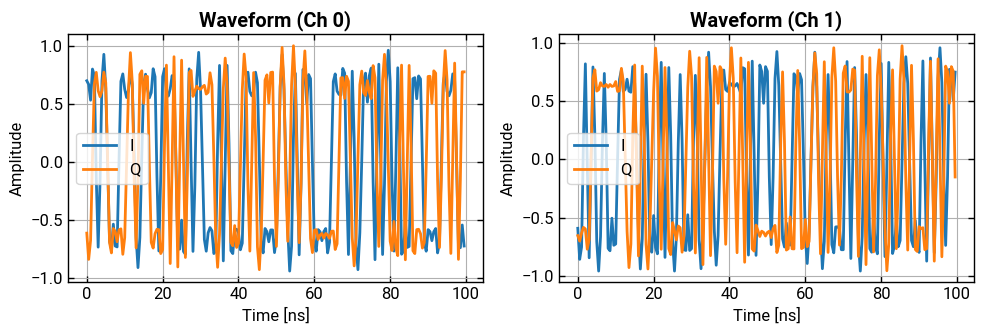

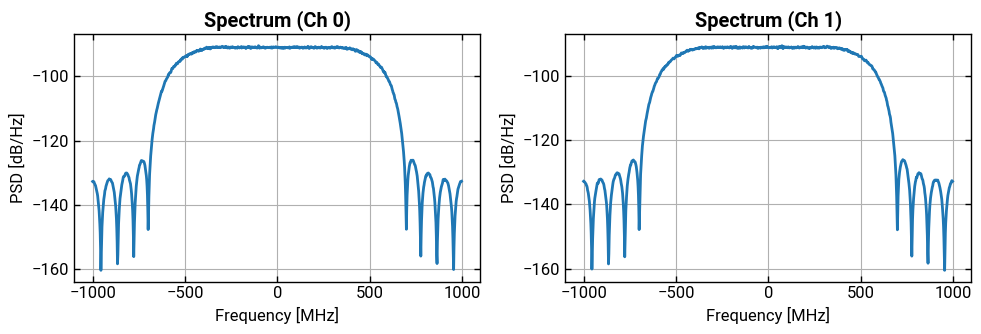

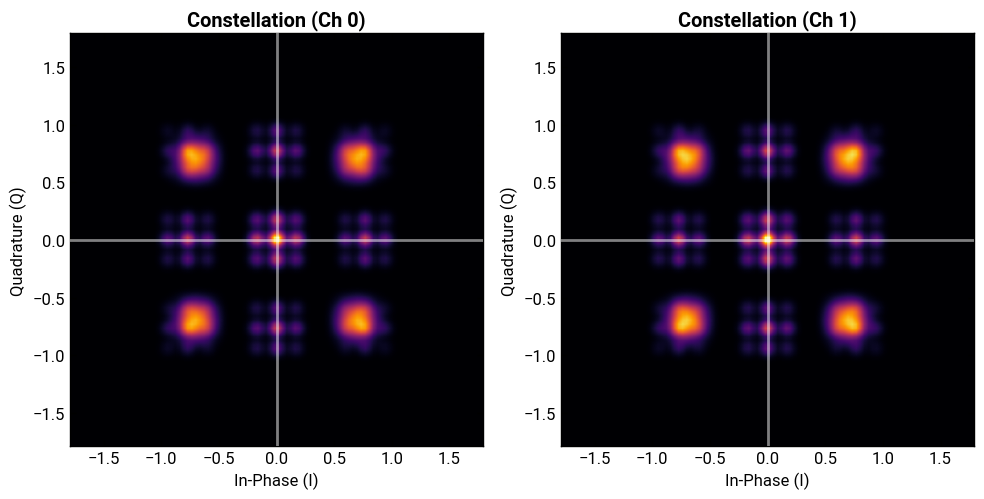

In [24]:
sig = Signal.qam(
    num_symbols=NUM_SYMBOLS,
    sps=SPS,
    symbol_rate=SYMBOL_RATE,
    order=ORDER,
    num_streams=2,
    seed=42,
)
sig.print_info()
sig.plot_waveform(num_symbols=100, show=True)
sig.plot_psd(show=True, nperseg=2**10)
sig.plot_constellation(show=True)


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 4
3,Symbol Rate,1.00 GBaud
4,Bit Rate,2.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,262.14 µs
9,Center Frequency,0.00 Hz


2026-02-22 18:01:33 [INFO] [commstools/impairments.py] Adding AWGN (Es/N0 target: 20.00 dB).


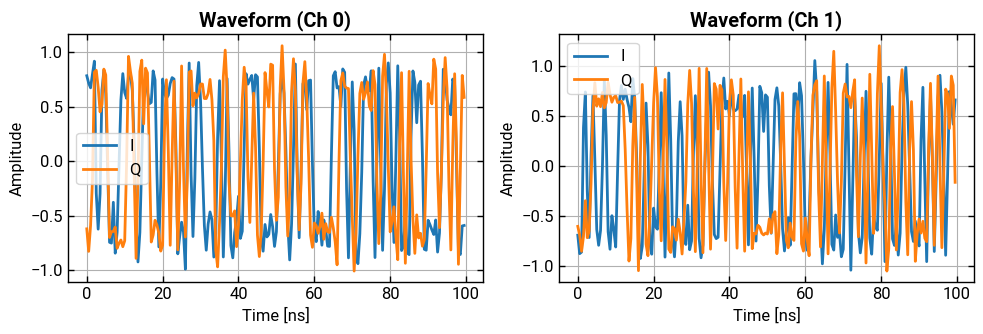

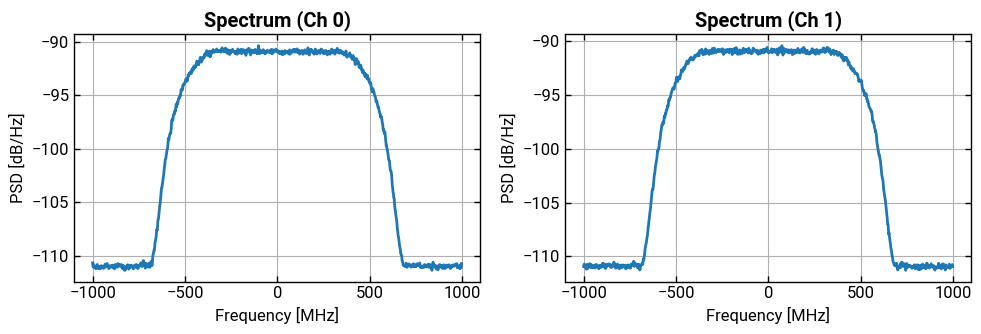

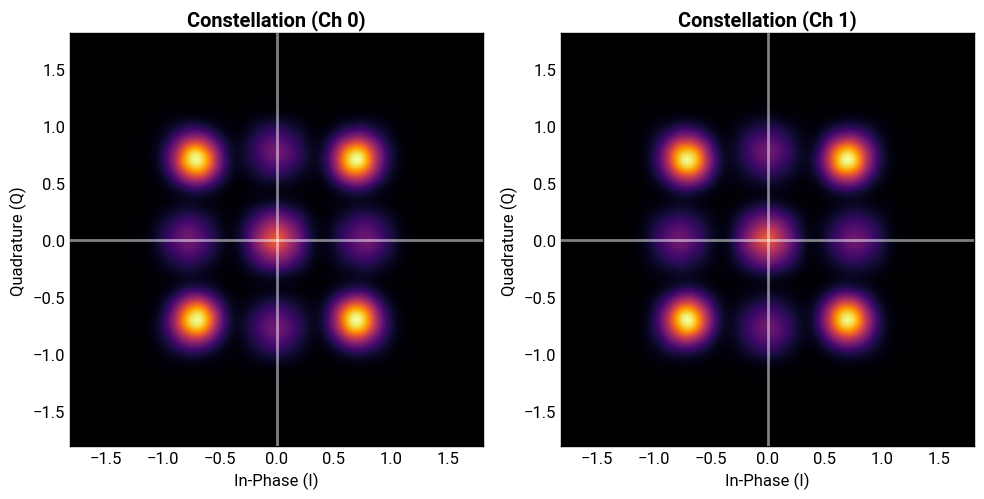

In [25]:
sig_dist = sig.copy()

sig_dist.print_info()
sig_dist = apply_awgn(sig_dist, esn0_db=ESN0_DB)
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-22 18:01:34 [INFO] [commstools/impairments.py] Applying PMD (DGD=0.00e+00 s, theta=0.785 rad).


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 4
3,Symbol Rate,1.00 GBaud
4,Bit Rate,2.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,262.14 µs
9,Center Frequency,0.00 Hz


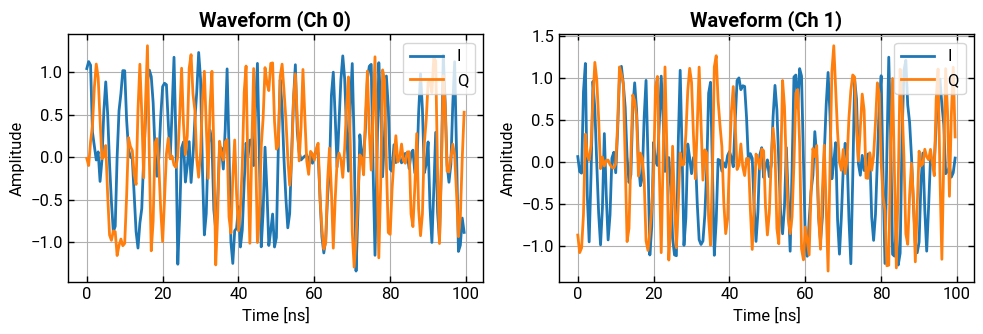

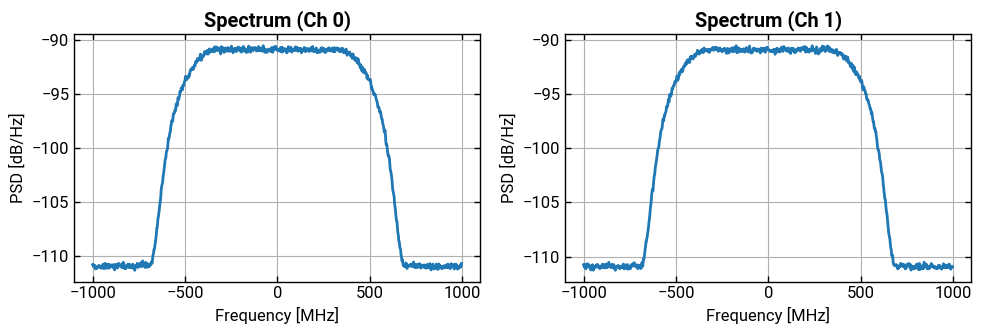

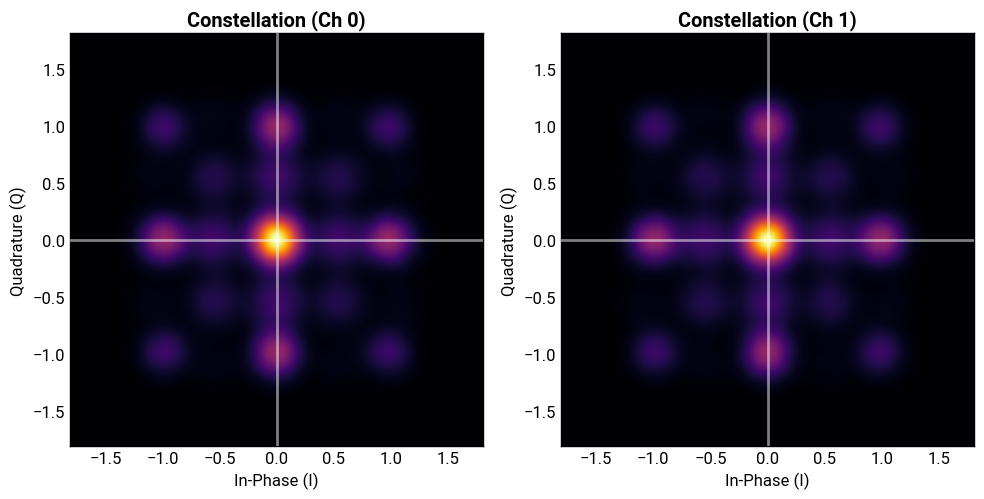

In [26]:
sig_dist = apply_pmd(sig_dist, dgd=DGD_SYMBOLS / SYMBOL_RATE, theta=THETA)

sig_dist.print_info()
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-22 18:01:34 [INFO] [commstools/core.py] Generating shaping filter taps (shape: rrc).


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 4
3,Symbol Rate,1.00 GBaud
4,Bit Rate,2.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,262.14 µs
9,Center Frequency,0.00 Hz


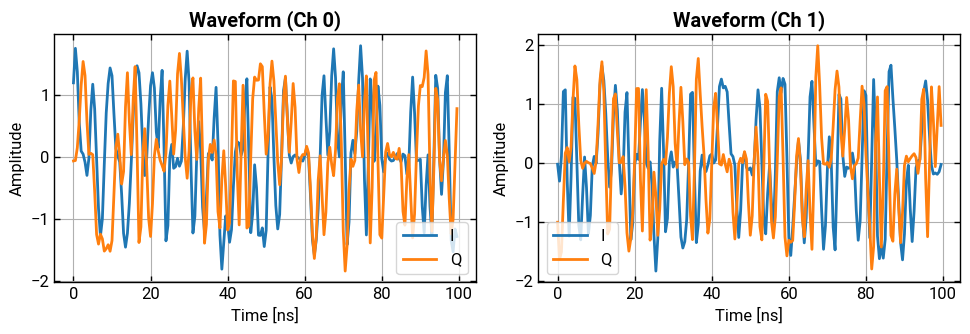

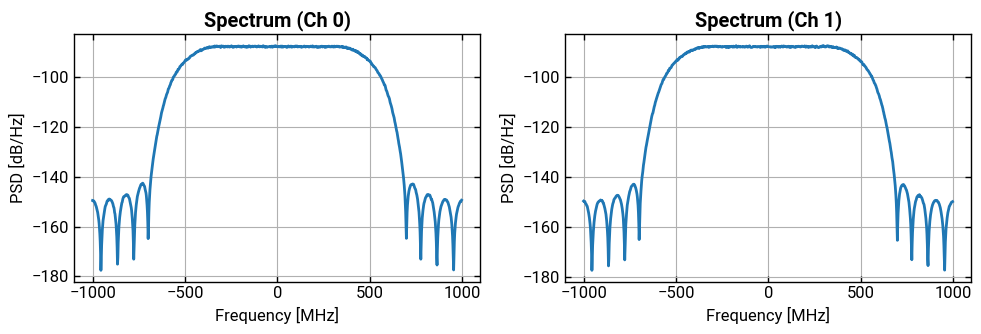

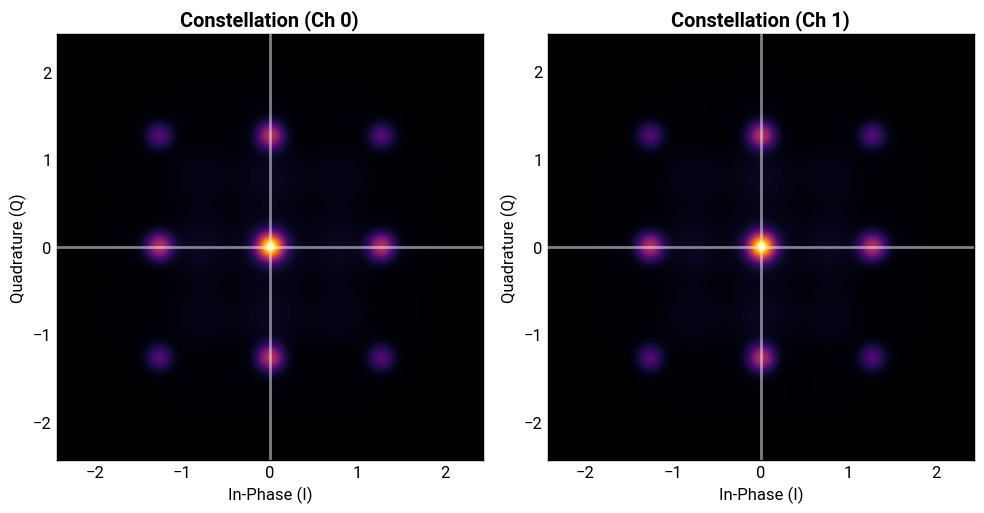

In [27]:
sig_dist.matched_filter()

sig_dist.print_info()
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-22 18:02:57 [INFO] [commstools/equalizers.py] LMS equalizer: num_taps=53, mu=0.1, sps=2, normalize=True, block_size=1


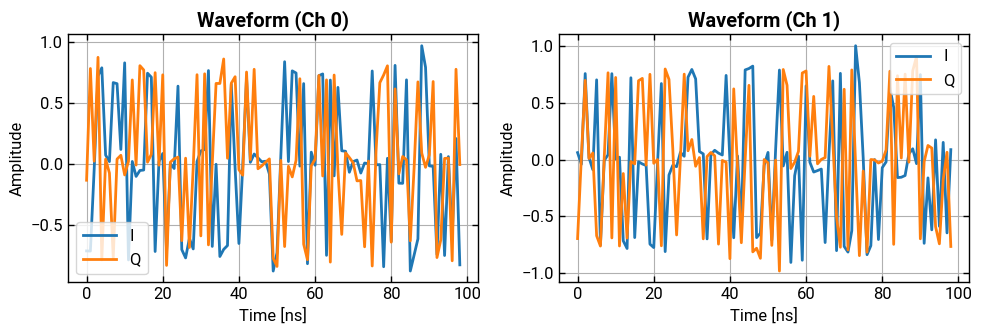

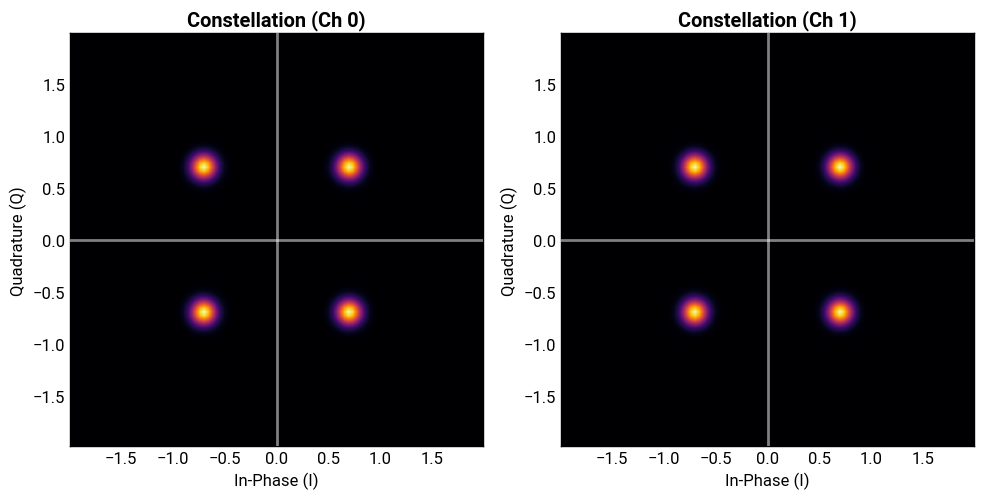

In [46]:
sig_to_eq = sig_dist.copy()

sig_to_eq.equalize(
    method="lms",
    step_size=0.1,
    num_train_symbols=0,
    block_size=1,
    num_taps=53,
    device="cpu",
)
sig_to_eq.plot_waveform(num_symbols=99, show=True)
sig_to_eq.plot_constellation(show=True)


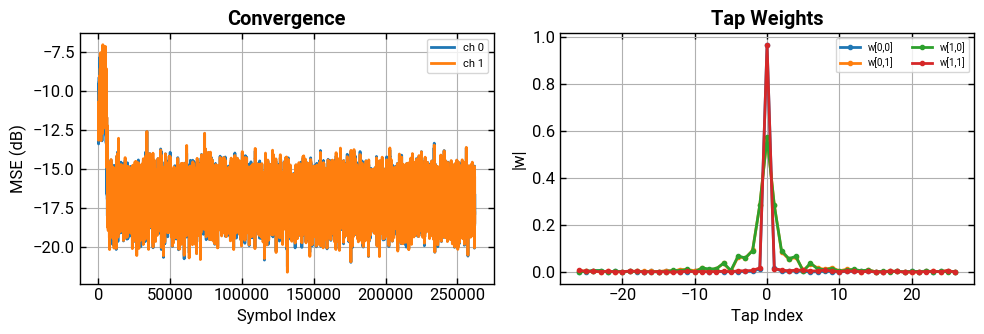

In [45]:
sig_to_eq.plot_equalizer(show=True)


In [47]:
sig_to_eq.resolve_symbols()
sig_to_eq.evm()


2026-02-22 18:03:05 [INFO] [commstools/core.py] Signal already at 1 sps, no downsampling needed.
2026-02-22 18:03:05 [INFO] [commstools/metrics.py] EVM Ch0: 141.43% (3.01 dB)
2026-02-22 18:03:05 [INFO] [commstools/metrics.py] EVM Ch1: 141.46% (3.01 dB)


(array([141.4288 , 141.45912], dtype=float32),
 array([3.0107574, 3.012619 ], dtype=float32))

In [31]:
sig_to_eq.resolved_symbols


array([[-0.04694273+7.8184533e-01j, -0.01202911+2.7888004e-02j,
         0.6987365 +2.4754811e-02j, ...,  0.03941558+3.2838915e-02j,
         0.00793977+4.9198600e-03j, -0.00686968-1.1811239e-02j],
       [-0.7319318 +1.5310174e-02j,  0.66081613+6.3584679e-01j,
         0.0157085 +8.4079689e-01j, ..., -0.04634306+7.1966643e-03j,
        -0.01999394+2.4684875e-03j,  0.01439111-7.2961213e-04j]],
      shape=(2, 262144), dtype=complex64)

In [32]:
sig_to_eq.source_symbols


array([[ 0.7071068-0.7071068j,  0.7071068-0.7071068j,
         0.7071068+0.7071068j, ..., -0.7071068-0.7071068j,
         0.7071068-0.7071068j,  0.7071068-0.7071068j],
       [-0.7071068-0.7071068j, -0.7071068-0.7071068j,
         0.7071068-0.7071068j, ...,  0.7071068+0.7071068j,
         0.7071068-0.7071068j, -0.7071068-0.7071068j]],
      shape=(2, 262144), dtype=complex64)

In [ ]:
51 // 2


25

In [ ]:
7 // 2


3